In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal

In [2]:
# setting hyperparameters
S = 10 # sessions
T = 500 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

In [3]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


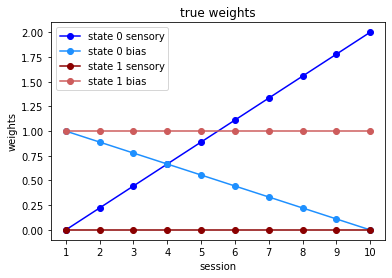

(5000, 2, 2, 2)


In [4]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)
plotting_weights(trueW,sessInd,'true weights')
print(trueW.shape)

In [5]:
# initialize object
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

In [6]:
# simualating data from true weight and transition matrices
# simX, simY, simZ = dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True)

# loading from previously simulateed
simX = np.load('../data/simX.npy')
simY = np.load('../data/simY.npy')
simZ = np.load('../data/simZ.npy')
simPhi = dGLM_HMM.observation_probability(simX, trueW)

In [7]:
alpha, ct, ll = dGLM_HMM.forward_pass(simY[2000:2500], trueP, simPhi[2000:2500,:,:])
beta = dGLM_HMM.backward_pass(simY[2000:2500,], trueP, simPhi[2000:2500,:,:], ct)
gamma, zeta = dGLM_HMM.posteriorLatents(simY[2000:2500], trueP, simPhi[2000:2500,:], alpha, beta, ct)
print(zeta)

[[[0.82373902 0.01056502]
  [0.01866103 0.14703493]]

 [[0.81676383 0.02563622]
  [0.00777027 0.14982968]]

 [[0.80834669 0.01618741]
  [0.01319071 0.16227519]]

 ...

 [[0.92985242 0.01005515]
  [0.00786218 0.05223024]]

 [[0.92807136 0.00964324]
  [0.00843597 0.05384942]]

 [[0.91212678 0.02438055]
  [0.00364466 0.05984801]]]


In [8]:
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['normal', (0,1)])

In [9]:
dGLM_HMM.weight_loss_function(np.ndarray.flatten(trueW[2000,:,:,0]), simX[2000:2500], simY[2000:2500], gamma, trueW[1500], trueW[2500], reshapeSigma(0.5,2,2))

290.0076127251935

In [7]:
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(simX, simY,  initP, initW, sigma=reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=5, tol=1e-3) # fit the model
            

0
4.205360654261297e-66
1.3115185945264302e-56
4.2053712086784614e-66
1.3115185945264302e-56
4.205357653651661e-66
1.3115185945264302e-56
4.205360654261297e-66
1.3115155118237722e-56
4.205360654261297e-66
1.3115193275261934e-56
4.205360654261297e-66
1.3115185945264302e-56
4.6012893344008926e-20
3.4376353080876795e-21
4.6012893344008926e-20
3.4376353080876795e-21
4.601295625456278e-20
3.4376353080876795e-21
4.601287123482819e-20
3.4376353080876795e-21
4.6012893344008926e-20
3.4376302291372425e-21
4.6012893344008926e-20
3.4376359282280855e-21
3.5951113138452934e-280
0.0
3.5951113138452934e-280
0.0
3.595092723312002e-280
0.0
3.5951163438803257e-280
0.0
3.5951113138452934e-280
0.0
3.5951113138452934e-280
0.0
4.6012893344008926e-20
3.4376353080876795e-21
4.6012893344008926e-20
3.4376353080876795e-21
4.601295625456278e-20
3.4376353080876795e-21
4.601287123482819e-20
3.4376353080876795e-21
4.6012893344008926e-20
3.4376302291372425e-21
4.6012893344008926e-20
3.4376359282280855e-21
4.6012893344

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


1.687392649901751e-17
2.4545969829732688e-23
1.6873948055113245e-17
2.4545969829732688e-23
1.6873918839539232e-17
2.4545969829732688e-23
1.687392649901751e-17
2.4545931527923212e-23
1.687392649901751e-17
2.4545969830177607e-23
2.955505406639802e-14
6.037845068675873e-20
2.955505406639802e-14
6.037845068675873e-20
2.955508819755816e-14
6.037845068675873e-20
2.955504178400894e-14
6.037845068675873e-20
2.955505406639802e-14
6.037836348548479e-20
2.955505406639802e-14
6.037844778920385e-20
2.5882103243401715e-18
1.6512736402282236e-59
2.5882103243401715e-18
1.6512736402282236e-59
2.5882088903689078e-18
1.6512736402282236e-59
2.5882070358922185e-18
1.6512736402282236e-59
2.5882103243401715e-18
1.6512698897265927e-59
2.5882103243401715e-18
1.6512752707038484e-59
1.0918293887166492e-11
4.1521160986451275e-22
1.0918293887166492e-11
4.1521160986451275e-22
1.0918304810604737e-11
4.1521160986451275e-22
1.0918288506565349e-11
4.1521160986451275e-22
1.0918293887166492e-11
4.1521097917856447e-22
1.0

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0.0
0.0
0.0
0.0
0.0011164943728114226
1.3151675514619866e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164943728114226
1.3151675514619866e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164949646225374
1.3151634567890018e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164939494268632
1.3151699038160612e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164943728114226
1.3151675514619866e-125
0.0027784989804048883
8.064971389780212e-73
0.0011164943728114226
1.3151675514619866e-125
0.00277849665163958
8.064979883810333e-73
0.0011164943728114226
1.3151675514619866e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164943728114226
1.3151675514619866e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164949646225374
1.3151634567890018e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164939494268632
1.3151699038160612e-125
0.0027784981731354868
8.064960613194992e-73
0.0011164943728114226
1.3151675514619866e-125
0.0027784989804048883
8.064971389780212e

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


6.1676115715210774e-15
3.6018309170557877e-65
6.952534233374901e-16
1.4984640115687387e-53
6.1676151606013375e-15
3.6018328735341307e-65
6.952532595752704e-16
1.4984606079101613e-53
6.1676151606013375e-15
3.6018328735341307e-65
6.952525391398475e-16
1.4984649169318703e-53
6.737128203114827e-09
2.8707618753327187e-52
3.24771119717024e-11
2.073687176929021e-50
6.737128203114827e-09
2.8707618753327187e-52
3.24771119717024e-11
2.073687176929021e-50
6.737134011687506e-09
2.870768429633107e-52
3.24771119717024e-11
2.073687176929021e-50
6.7371250782782425e-09
2.870760655002341e-52
3.24771119717024e-11
2.073687176929021e-50
6.737128203114827e-09
2.8707618753327187e-52
3.247710856580048e-11
2.0736827376634628e-50
6.737128203114827e-09
2.8707618753327187e-52
3.247707662695904e-11
2.0736888102906058e-50
3.295417315378917e-154
4.394420439703324e-114
1.5995448053000625e-62
4.293263435517906e-73
3.295417315378917e-154
4.394420439703324e-114
1.5995448053000625e-62
4.293263435517906e-73
3.295410520061

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0.2979971229854373
1.6333315192155856e-24
0.8010014357208883
3.917128195646405e-84
0.29799723912295095
1.6333342564676565e-24
0.8010014357208883
3.917128195646405e-84
0.29799724792571375
1.633334126896276e-24
0.8010017269637065
3.9171359483579135e-84
0.29799724792571375
1.633334126896276e-24
0.8010014543822077
3.9171196723685577e-84
5.500794194410056
7.050207764490295e-18
3.651378938849204
6.020566117379563e-66
5.500794194410056
7.050207764490295e-18
3.651378938849204
6.020566117379563e-66
5.500793253879885
7.050198259026765e-18
3.651378938849204
6.020566117379563e-66
5.500794931303632
7.050209476495395e-18
3.651378938849204
6.020566117379563e-66
5.500794194410056
7.050207764490295e-18
3.651379298239925
6.020576436688226e-66
5.500794194410056
7.050207764490295e-18
3.651379800532973
6.020554297749591e-66
9.611815734172104e-45
5.9949400350827066e-80
0.0
0.0
9.611815734172104e-45
5.9949400350827066e-80
0.0
0.0
9.611805105536131e-45
5.994926348277166e-80
0.0
0.0
9.611798007969694e-45
5.994

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


5.784317750182537
2.6279892969965976e-18
10.040485484046181
3.7286515882391046e-65
5.784317750182537
2.6279892969965976e-18
10.040487351797452
3.7286380578827707e-65
6.605918560361016
6.548073809711563e-18
8.15134550953932
1.2208648428153102e-63
6.605918560361016
6.548073809711563e-18
8.15134550953932
1.2208648428153102e-63
6.60591736567833
6.5480649166251584e-18
8.15134550953932
1.2208648428153102e-63
6.605919086480701
6.548075044107408e-18
8.15134550953932
1.2208648428153102e-63
6.605918560361016
6.548073809711563e-18
8.151344931581766
1.2208667286608883e-63
6.605918560361016
6.548073809711563e-18
8.151346790291253
1.220862349716591e-63
10.191168379755261
2.2889691055186164e-16
2.355627560025289
9.33496074552109e-58
10.191168379755261
2.2889691055186164e-16
2.355627560025289
9.33496074552109e-58
10.191167125735141
2.288966129121915e-16
2.355627560025289
9.33496074552109e-58
10.191169075074551
2.288969510887645e-16
2.355627560025289
9.33496074552109e-58
10.191168379755261
2.2889691055

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0.12451674365843632
3.169199949930031e-37
1.5134716170186127
5.799260977973047e-170
0.1245166875090806
3.169191727592518e-37
1.5134716170186127
5.799260977973047e-170
0.12451668589003176
3.1691942708636304e-37
1.5134717180243098
5.7992400167728124e-170
0.12451668589003176
3.1691942708636304e-37
1.513472095704754
5.7992730925645324e-170
0.4728926425127053
2.0411356171699244e-34
3.431719954200986
2.281668054082976e-161
0.4728926425127053
2.0411356171699244e-34
3.431719954200986
2.281668054082976e-161
0.4728928285226098
2.04113913070478e-34
3.431719954200986
2.281668054082976e-161
0.4728926603928573
2.0411340297987007e-34
3.431719954200986
2.281668054082976e-161
0.4728926425127053
2.0411356171699244e-34
3.431720421319935
2.281659965385822e-161
0.4728926425127053
2.0411356171699244e-34
3.43172071852334
2.2816726069870913e-161
7.902342761355139
2.8210913326138192e-24
0.20140245783162206
1.2138761694208493e-129
7.902342761355139
2.8210913326138192e-24
0.20140245783162206
1.2138761694208493e-

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0.0023114930651528666
5.785304014356423e-11
5.111537844138003e-15
8.624424346264981e-95
0.002311494757225122
5.7853107878730744e-11
5.111537844138003e-15
8.624424346264981e-95
0.0023114944879469353
5.785304554100046e-11
5.1115436846606355e-15
8.624447821872437e-95
0.0023114944879469353
5.785304554100046e-11
5.11153514565191e-15
8.624411175312547e-95
0.0023114944879469353
5.785304554100046e-11
5.111537844138003e-15
8.624424346264981e-95
0.0023114944879469353
5.785304554100046e-11
5.111537844138003e-15
8.624424346264981e-95
0.0023114930651528666
5.785304014356423e-11
5.111537844138003e-15
8.624424346264981e-95
0.002311494757225122
5.7853107878730744e-11
5.111537844138003e-15
8.624424346264981e-95
0.0023114944879469353
5.785304554100046e-11
5.1115436846606355e-15
8.624447821872437e-95
0.0023114944879469353
5.785304554100046e-11
5.11153514565191e-15
8.624411175312547e-95
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.057e-321
0.0
2.0562637949945163e-109
1.0993875188754003e-68
3.9277901082241234e-92
2.9

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))



0.0
0.00017366489333721138
1.0144171859269083e-40
0.2738928302651691
6.141497421038831e-27
0.00017366489333721138
1.0144171859269083e-40
0.2738928302651691
6.141497421038831e-27
0.00017366501702160752
1.0144155416540536e-40
0.2738928302651691
6.141497421038831e-27
0.00017366489106406316
1.0144159087544325e-40
0.2738928302651691
6.141497421038831e-27
0.00017366489333721138
1.0144171859269083e-40
0.2738927209232036
6.14149453471514e-27
0.00017366489333721138
1.0144171859269083e-40
0.2738927905453559
6.141507290164315e-27
0.00017366489333721138
1.0144171859269083e-40
0.2738928302651691
6.141497421038831e-27
0.00017366489333721138
1.0144171859269083e-40
0.2738928302651691
6.141497421038831e-27
0.00017366501702160752
1.0144155416540536e-40
0.2738928302651691
6.141497421038831e-27
0.00017366489106406316
1.0144159087544325e-40
0.2738928302651691
6.141497421038831e-27
0.00017366489333721138
1.0144171859269083e-40
0.2738927209232036
6.14149453471514e-27
0.00017366489333721138
1.014417185926908

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0.005289529820629138
11.368478847182779
12.63004640638925
3.662294440445837e-15
0.005289530413708969
11.368479278074338
12.63004640638925
3.662294440445837e-15
0.0052895279062997
11.368480021330035
12.630045175834724
3.6622938508219085e-15
0.0052895279062997
11.368480021330035
12.630046054728457
3.662289846998423e-15
0.008045756783336784
10.273301444647208
12.954081920852794
2.1675243357456662e-14
0.008045756783336784
10.273301444647208
12.954081920852794
2.1675243357456662e-14
0.008045759575109456
10.273300230309202
12.954081920852794
2.1675243357456662e-14
0.0080457605283717
10.273300684995503
12.954081920852794
2.1675243357456662e-14
0.008045756783336784
10.273301444647208
12.954080683170416
2.167523990867397e-14
0.008045756783336784
10.273301444647208
12.954081969986552
2.1675216856915786e-14
0.037693236183447734
5.9956617339989835
9.119336340187655
1.691829927418406e-11
0.037693236183447734
5.9956617339989835
9.119336340187655
1.691829927418406e-11
0.037693247012621195
5.995660667

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


3.979570982573756e-06
3.1065102584901743e-40
6.533671083294159
1.4312682961751462e-07
3.979570982573756e-06
3.1065102584901743e-40
6.533670418892751
1.4312695639563734e-07
3.979570982573756e-06
3.1065102584901743e-40
6.533671607578078
1.431268266060054e-07
3.979570982573756e-06
3.1065102584901743e-40
6.533671607578078
1.431268266060054e-07
3.979568326385464e-06
3.10651502095369e-40
6.533671607578078
1.431268266060054e-07
3.979572889408581e-06
3.1065060762239346e-40
6.533671607578078
1.431268266060054e-07
3.979570982573756e-06
3.1065102584901743e-40
6.533671083294159
1.4312682961751462e-07
3.979570982573756e-06
3.1065102584901743e-40
6.533670418892751
1.4312695639563734e-07
8.027768904900007e-232
1.2167718985089807e-150
0.0
0.0
6.71355681122855e-72
2.309287959566475e-48
1.5137784989350113e-276
3.6e-322
3.0344412906392553e-27
1.5723879938195517e-32
5.579943149481641e-69
1.271152072211348e-95
9.618969922938143e-14
1.934582812018981e-33
3.9187587464402995e-17
2.768307091320217e-34
3.365310

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:366: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0.5488370809215745
0.08072266337228087
0.5488370809215745
0.08072266337228087
0.5488369317924925
0.08072266337228087
0.5488372319315397
0.08072266337228087
0.5488370809215745
0.0807226897410545
0.5488370809215745
0.08072263449747802
0.5488370809215745
0.08072266337228087
0.5488370809215745
0.08072266337228087
0.5488369317924925
0.08072266337228087
0.5488372319315397
0.08072266337228087
0.5488370809215745
0.0807226897410545
0.5488370809215745
0.08072263449747802
2.8797354088324495e-109
0.0
5.379459675972626e-21
3.635546400768394e-261
0.018532167258376153
8.259244893162183e-67
13.705460064758084
3.826109121985687e-18
9.364201054475718
6.131599457534711e-06
0.8741777860761425
0.06931837528618849
0.8741777860761425
0.06931837528618849
0.8741775661246038
0.06931837528618849
0.8741780099012298
0.06931837528618849
0.8741777860761425
0.06931839406593175
0.8741777860761425
0.06931834687206656
1.6565833591167545
0.003851181540478462
1.6565833591167545
0.003851181540478462
1.6565829920309703
0.00

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:370: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0.036276565072832376
5.408283378691064
0.03627658952829535
5.408283378691064
0.03627658261644505
5.4082831350215885
0.03627658261644505
5.4082845374192745
0.017518482671905124
2.0679732945765004
0.017518482671905124
2.0679732945765004
0.01751847415076192
2.0679732945765004
0.017518487169441346
2.0679732945765004
0.017518482671905124
2.0679731212191186
0.017518482671905124
2.0679738924996824
0.005642482359600756
1.489506945965753
0.005642482359600756
1.489506945965753
0.005642479328548099
1.489506945965753
0.005642483789829044
1.489506945965753
0.005642482359600756
1.4895069163219168
0.005642482359600756
1.4895074281657128
7.246068219793881e-06
0.004175726974672882
7.246068219793881e-06
0.004175726974672882
7.246067946512523e-06
0.004175726974672882
7.246074048500235e-06
0.004175726974672882
7.246068219793881e-06
0.0041757294426948855
7.246068219793881e-06
0.00417572751682822
0.005868846165939236
1.5238759081885156
0.005868846165939236
1.5238759081885156
0.0058688430334848775
1.52387590

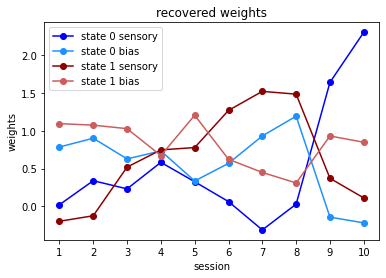

In [14]:
plotting_weights(checkW, sessInd, 'recovered weights')

In [7]:
sigmaList = [0.1,1,10]
sigmaList = [reshapeSigma(s, K, D) for s in sigmaList]
weightDistributionList = [['uniform', (-2,2)], ['normal', (0,1)]]
inits = 2 # set the number of initializations
maxiter = 250 #250
# store values for each model
allLl = np.zeros((len(sigmaList),len(weightDistributionList),inits,maxiter))
allP = np.zeros((len(sigmaList),len(weightDistributionList),inits, K,K))
allW = np.zeros((len(sigmaList),len(weightDistributionList),inits,N,K,D,C))
for ind1 in range(0, len(sigmaList)):
    for ind2 in range(0, len(weightDistributionList)):
        for ind3 in range(0, inits):

            # fit the model for each 
            initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=weightDistributionList[ind2]) # initialize the model parameters
            allP[ind1,ind2,ind3], allW[ind1,ind2,ind3], allLl[ind1,ind2,ind3] = dGLM_HMM.fit(simX, simY,  initP, initW, sigma=sigmaList[ind1], sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
            

0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

3
4
5
6
7
8
9
10
11
12
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarni

2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


3


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


4


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


5


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


6


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


7


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


8


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


9


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


10


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


11


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


12


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


13


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


14


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


15


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


16


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


17


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


18


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


19


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


20


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


21


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


22


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


23


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


24


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


25


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


26


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


27


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


28


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


29


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


30


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


31


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


32


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


33


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


34


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


35


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarni

1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


3
4
5
6


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
0
1
2
3
4
5
6
7
8


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


53
54
55
56
57
58


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


59
60
61


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
0
1
2
3
4
5
6
7
8
9
10
11


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


12
13
14
15
16
17
18
19
20
21
22


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


23
24
25
26
27
28


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


29
30
31
32
33
34
35
36
37
38


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


39
40
41
42
43
44
45
46
47
48
49
50
51


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
0


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


1
2


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


22
23
24
25
26
27
28
29


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


30
31
32
33
34


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


35
36
37
38


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


59
60
61
62
63
64


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


65
0
1
2
3


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


46
47
48
49
50
51
52
53
54
55
56
57


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


58
59
60
61


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


62
63
64
65
66
67
68
69


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


70
71
72
73


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


74
75
76
77


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


78


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


79
80
81
82
83
84
85
86
87
88
89


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


90
91
92
93
94
95
96
97
98
99
100


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


101
102
103
104
105
106


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


107
108
109
110
111
112
113
114
115
116
117
118
119
0
1
2
3


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


24
25
26
27
28
29
30
31
32
33
34


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


35
36
37
38
39


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


40
41
42
43
44
45
46
47
48
49
50
51
0


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


15
16
17
18
19
20
21
22
23


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


24
25
26
27
28
29
30
31


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


105


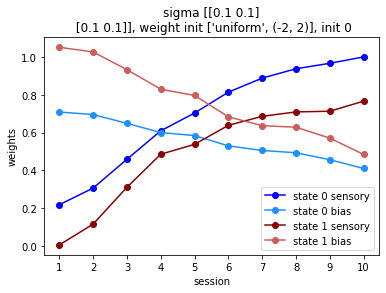

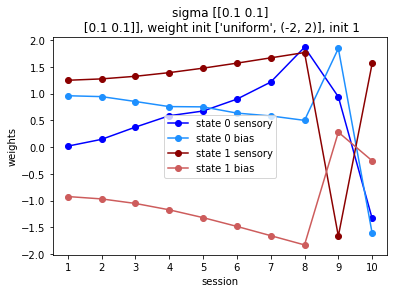

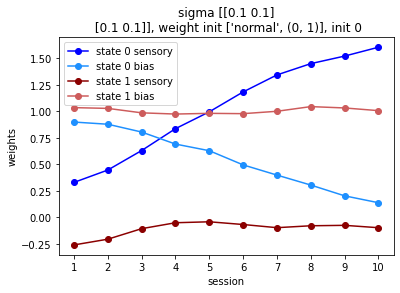

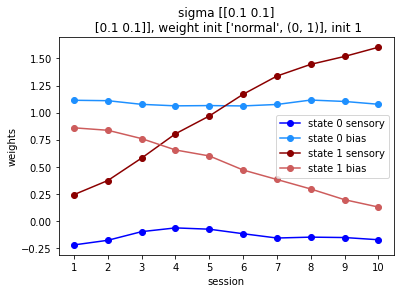

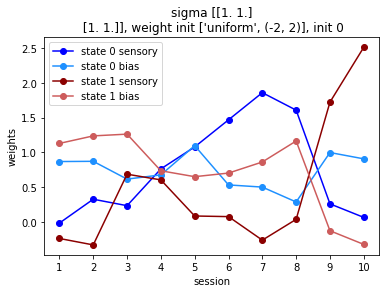

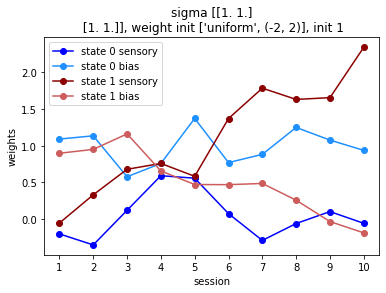

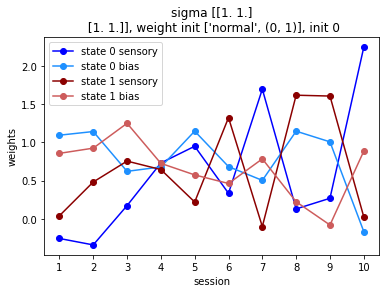

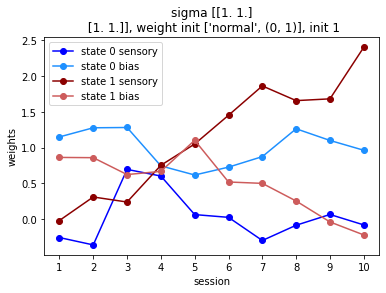

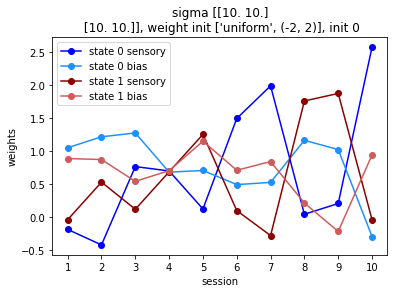

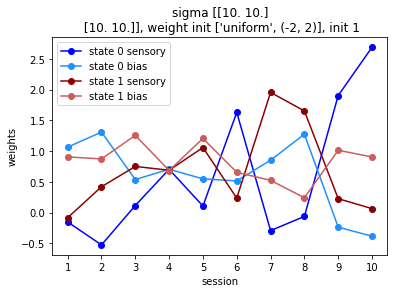

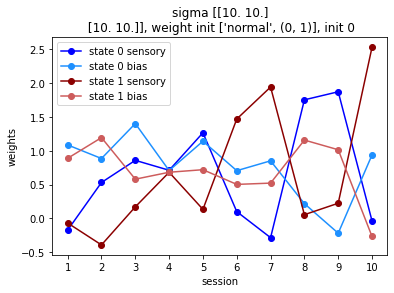

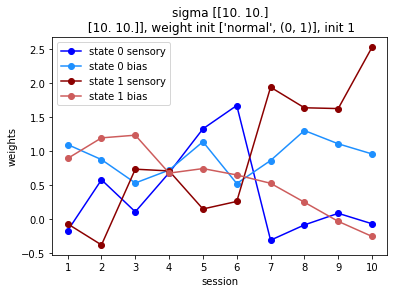

In [8]:
for ind1 in range(0, len(sigmaList)):
    for ind2 in range(0, len(weightDistributionList)):
        for ind3 in range(0, inits):
            plotting_weights(allW[ind1,ind2,ind3],sessInd,f'sigma {sigmaList[ind1]}, weight init {weightDistributionList[ind2]}, init {ind3}')

In [ ]:
# what is the perfect sigma for each state???
